#### This notebook contains the data processing and modelling steps for training a ham/spam classifier.
#### The dataset consists of 5572 SMS labelled messages taken from the [UC Irvine ML Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)
#### The structure of this notebook is as follows:
[1) Data import ](#section_1)<br>
[2) Test set creation ](#section_2)<br>
[3) Bag-of-words vs sequence models ](#section_3)<br>
[4) Data exploration and processing ](#section_4)<br>
[5) Vectorization ](#section_5)<br>
[6) Model selection ](#section_6)<br>
[7) Pipeline ](#section_7)<br>
[8) Hyperparameter tuning ](#section_8)<br>
[9) Test set evaluation ](#section_9)<br>
[10) Final comments ](#section_10)<br>

In [97]:
# Standard libraries
import re
import string
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import html

# Scikit-Learn
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# NLP tools
import urlextract
import tldextract
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download("stopwords")
from nltk.corpus import stopwords
from spellchecker import SpellChecker

# Import dictionary to expand contractions
from contractions_mapping import CONTRACTIONS

# Assign the list of NLTK stopwords to a constant
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Set-up and read in the data:<a id='section_1'></a>

Set the data directory:

In [98]:
DATA_DIR = "../data/raw"

Create a random number generator state for use throughout the code:

In [99]:
rng = np.random.RandomState(0)

Read in the csv as a dataframe:

In [100]:
df = pd.read_csv(f"{DATA_DIR}/SMSSpamCollection", sep='\t', names=["ham_or_spam", "sms"])

Let's look at the first few entries:

In [101]:
df.head()

,ham_or_spam,sms
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ham_or_spam  5572 non-null   object
 1   sms          5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


No missing data.

In [103]:
# So that we can read all the text in a cell:
pd.options.display.max_colwidth = int(df["sms"].str.len().max())

In [104]:
df.head(10)

,ham_or_spam,sms
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [105]:
df.describe()

,ham_or_spam,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


We can see that we have some duplicates among the sms messages.

### Duplicates:
Whilst dropping valid duplicate entries in a dataset is not something you would want to do if you were confident that the sample data were representative of the population, in this case, specific, identical, repeated text messages are more likely to be a quirk of this sample, and not so likely to persist into the future. Therefore, I think a better generalising model would result from the data with those duplicates removed: 1) in case the model over-fitted to those specific instances and 2) if, by chance, the majority of duplicates ended up in any particular sub-sample, e.g. training, validation or testing.

In [106]:
df = df.drop_duplicates(ignore_index=True)

Time to replace 'ham' and 'spam' with integer labels:

In [107]:
df["ham_or_spam"] = df["ham_or_spam"].replace(["ham", "spam"], [0, 1])
df.head()

/var/folders/qp/lq02j6hd7h17b7fmxkkpzblc0000gn/T/ipykernel_2442/261106689.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ham_or_spam"] = df["ham_or_spam"].replace(["ham", "spam"], [0, 1])


,ham_or_spam,sms
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


Let's check the proportion of ham vs spam:

In [108]:
df["ham_or_spam"].value_counts()/len(df)

ham_or_spam
0    0.87367
1    0.12633
Name: count, dtype: float64

# 2) Separate out a hold-out test set: <a id='section_2'></a>

I'll make an 80/20 split: training and validating on 80%, with a final evaluation on the hold-out 20% at the end of the project.

I'll use stratified sampling to ensure that the spam messages are evenly dispersed among the train and test sets.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df["sms"], df["ham_or_spam"], test_size=0.2, random_state=rng, stratify=df["ham_or_spam"])

Check that the proportions in the test set match the original proportions:

In [110]:
y_test.value_counts()/len(y_test)

ham_or_spam
0    0.873308
1    0.126692
Name: count, dtype: float64

# 3) Bag-of-words or sequence models? <a id='section_3'></a>

In his book, Deep Learning with Python, François Chollet mentions a rule of thumb for when a bag-of-words is likely to work as well (or better) than a sequence model for text classification. He says that the ratio of “number of samples” to “number of words per sample” correlates with model performance, and that when that ratio is small (<1500), you may find the bag-of-words approach to be a good option. As that ratio is much smaller than 1500 for this data set (see cell below), I will not use sequence models or word embeddings, but rather stick to standard classifiers from scikit-learn and bag-of-words-type encoding of the data. 

In [111]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train["n_words"] = df_train["sms"].str.split().str.len()

print("N_samples/N_words_per_sample: ", int(len(df_train) / df_train["n_words"].median()))

N_samples/N_words_per_sample:  344


# 4) Explore and process the training data <a id='section_4'></a>

In [112]:
df_train.sample(10)

,sms,ham_or_spam,n_words
3678,Serious? What like proper tongued her,0,6
2042,I hope you know I'm still mad at you.,0,9
731,Just got up. have to be out of the room very soon. …. i hadn't put the clocks back til at 8 i shouted at everyone to get up and then realised it was 7. wahay. another hour in bed.,0,40
3641,"not that I know of, most people up here are still out of town",0,14
2163,"Thanks for your ringtone order, ref number R836. Your mobile will be charged £4.50. Should your tone not arrive please call customer services on 09065069154",1,25
3649,did u get that message,0,5
4079,"Our dating service has been asked 2 contact U by someone shy! CALL 09058091870 NOW all will be revealed. POBox84, M26 3UZ 150p",1,23
1047,URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050003091 from land line. Claim C52. Valid12hrs only,1,27
600,Neva mind it's ok..,0,4
3343,If you are not coughing then its nothing,0,8


It might be interesting to see if there are differences in typical message lengths for ham vs spam:

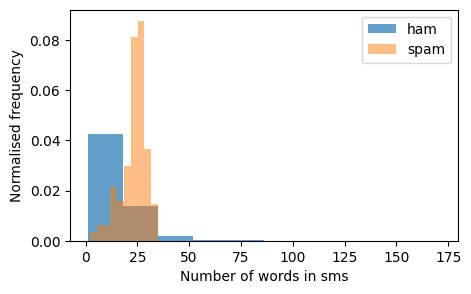

In [113]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(df_train["n_words"][df_train["ham_or_spam"]==0],  alpha=0.7, label="ham", density=True)
ax.hist(df_train["n_words"][df_train["ham_or_spam"]==1],  alpha=0.5, label="spam", density=True)
ax.set_xlabel("Number of words in sms")
ax.set_ylabel("Normalised frequency")
ax.legend();

It is evident that, on average, ham is more succinct than spam! <br>
It is interesting to observe in itself, but the number of words per message could be a potential feature in the model. Although that information is probably going to be contained in the final bag-of-words matrix anyway.

It would also be interesting to compare the most-common words present. Here's a function to pull out that information:

In [114]:
def get_top_n_words(
    data: pd.Series | list[str],
    top_n: int | None = None,
    exclude_list: list[str] | None = None,
) -> list[tuple]:
    """Get the top_n words and their frequencies from a corpus of text.
    Scikit-Learn's CountVectorizer is used to create the matrix of vocabulary and counts.
    A list of word and count tuples is returned.
    Words provided in the optional exclude_list are excluded.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    top_n : int | None, optional
        Get the n most frequently occuring words in the given data, by default None
    exclude_list : list[str] | None
        Optional list of words to exclude in data returned, by default True 
    
    Returns
    -------
    list[tuple]
        List of word and count tuples for the top_n words.
    """
    vectorizer = CountVectorizer()
    matrix = vectorizer.fit_transform(data)
    sum_words = matrix.sum(axis=0)
    if exclude_list is None:
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
        ]
    else:
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items() if word not in exclude_list
        ]

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    if top_n is not None:
        return words_freq[:top_n]
    else:
        return words_freq

Let's fetch the words and their frequencies, excluding the stopwords:

In [115]:
word_frequencies_ham = get_top_n_words(data=df_train["sms"][df_train["ham_or_spam"]==0], exclude_list=STOPWORDS)
word_frequencies_spam = get_top_n_words(data=df_train["sms"][df_train["ham_or_spam"]==1], exclude_list=STOPWORDS)

In [116]:
pd.DataFrame({"Ham": word_frequencies_ham[:20], "Spam": word_frequencies_spam[:20]})

,Ham,Spam
0,"(gt, 238)","(call, 247)"
1,"(lt, 236)","(free, 153)"
2,"(get, 234)","(txt, 108)"
3,"(ok, 202)","(text, 95)"
4,"(go, 200)","(ur, 87)"
5,"(got, 193)","(mobile, 87)"
6,"(like, 178)","(stop, 85)"
7,"(know, 177)","(claim, 76)"
8,"(good, 166)","(reply, 73)"
9,"(come, 161)","(prize, 70)"


We see some commonalities, e.g. "call" (unsurprisingly) and some 'incentive'-type language in the spam, e.g. "free", "claim", "prize", as well as parts of URLs.

There are a number of potential pre-processing steps which could be employed here, such as:
- Conversion to lower case
- Spelling correction
- Stemming
- Removing punctuation
- Replacement or removal of URLs
- Replacement or removal of numbers
- Deal with HTML character codes

Let's look at HTML characters first, with a function to unescape such characters:

## 4a) HTML

In [117]:
def unescape_html(
    data: pd.Series | list[str],
) -> list[str]:
    """Convert all named and numeric character references (e.g. &gt;, &#62;, &#x3e;)
    in the string to the corresponding Unicode characters.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data

    Returns
    -------
    list[str]
        Text data with html unescaped.
    """
    processed_text = []
    for text in data:
        text = html.unescape(text)
        processed_text.append(text)
    return processed_text

Let's apply it to the training data (creating a new column in the df for the processed results):

In [118]:
df_train["sms_processed"] = df_train["sms"]

In [119]:
df_train["sms_processed"] = unescape_html(data=df_train["sms_processed"])

## 4b) URLs

In [120]:
# urlextract extracts potential URLs based on a list of top-level domains (TLDs)
url_extractor = urlextract.URLExtract()

for text in df_train["sms"]:
    urls = list(set(url_extractor.find_urls(text, with_schema_only=False)))
    if len(urls) > 0:
        print(text)
        print("URLs: ", urls)

Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821
URLs:  ['NoWorriesLoans.com']
No drama Pls.i have had enough from you and family while i am struggling in the hot sun in a strange place.No reason why there should be an ego of not going 'IF NOT INVITED' when actually its necessity to go.wait for very serious reppurcussions.
URLs:  ['place.No']
New TEXTBUDDY Chat 2 horny guys in ur area 4 just 25p Free 2 receive Search postcode or at gaytextbuddy.com. TXT ONE name to 89693
URLs:  ['gaytextbuddy.com']
Moby Pub Quiz.Win a £100 High Street prize if u know who the new Duchess of Cornwall will be? Txt her first name to 82277.unsub STOP £1.50 008704050406 SP Arrow
URLs:  ['Quiz.Win']
FreeMsg: Claim ur 250 SMS messages-Text OK to 84025 now!Use web2mobile 2 ur mates etc. Join Txt250.com for 1.50p/wk. T&C BOX139, LA32WU. 16 . Remove txtX or stop
URLs:  ['Txt250.com']
Dear Voucher Holder, To claim this weeks offer, at you PC please go to ht

Perfect URL removal can be tricky. <br>
The above shows instances where non-URLs are identified as URLs because of missing spaces after full-stops, and also at least one instance where a URL is split into parts.

We can use tldextract to pull out the tlds from the identified urls:

In [121]:
tld_list = []
for text in df_train["sms"]:
    text = text.lower()
    urls = list(set(url_extractor.find_urls(text)))
    if len(urls) > 0:
        tlds = [tldextract.extract(i).suffix for i in urls]
        tld_list.append(tlds)
# Flatten the list of lists:
tld_list = set([item for row in tld_list for item in row])
print(tld_list)

{'you', '', 'ac', 'it', 'info', 'be', 'co.uk', 'love', 'life', 'net', 'name.my', 'biz', 'meet', 'how', 'to', 'by', 'no', 'org.uk', 'win', 'ice', 'like', 'my', 'pa', 'com', 'free', 'do', 'call', 'in', 'now', 'tv', 'hsbc', 'im', 'so'}


I'll make a list of the likely genuine TLDs for this data set and then only return URLs which include them:

In [122]:
REAL_TLDS = ["com", "org.uk", "net", "co.uk", "biz", "edu", "ac", "edu.sg", "tv"]

for text in df_train["sms"]:
    text = text.lower()
    urls = list(set(url_extractor.find_urls(text)))
    urls = [s for s in urls if any(tld in s for tld in REAL_TLDS)]
    if len(urls) > 0:
        print(text)
        print("URLs: ", urls)

loans for any purpose even if you have bad credit! tenants welcome. call noworriesloans.com on 08717111821
URLs:  ['noworriesloans.com']
no drama pls.i have had enough from you and family while i am struggling in the hot sun in a strange place.no reason why there should be an ego of not going 'if not invited' when actually its necessity to go.wait for very serious reppurcussions.
URLs:  ['place.no']
new textbuddy chat 2 horny guys in ur area 4 just 25p free 2 receive search postcode or at gaytextbuddy.com. txt one name to 89693
URLs:  ['gaytextbuddy.com']
freemsg: claim ur 250 sms messages-text ok to 84025 now!use web2mobile 2 ur mates etc. join txt250.com for 1.50p/wk. t&c box139, la32wu. 16 . remove txtx or stop
URLs:  ['txt250.com']
dear voucher holder, to claim this weeks offer, at you pc please go to http://www.e-tlp.co.uk/reward. ts&cs apply.
URLs:  ['http://www.e-tlp.co.uk/reward.']
important information 4 orange user 0789xxxxxxx. today is your lucky day!2find out why log onto h

This seems to work, in that I don't see any more false positives, so let's write a function:

In [123]:
def remove_urls_by_tld(
    data: pd.Series | list[str], tld_list: list[str], replace_str: str | None
) -> list[str]:
    """Remove urls in the data if the url contains a top-level domain matching
    one in tld_list. URLs are removed or optionally replaced with a provided string.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    tld_list : list[str]
        List of top-level domains to consider
    replace_str : str | None
        Optional string replacement for URL

    Returns
    -------
    list[str]
        Text data with URLs removed or replaced.
    """
    url_extractor = urlextract.URLExtract()
    processed_text = []
    for text in data:
        text = text.lower()
        urls = list(set(url_extractor.find_urls(text)))
        urls = [s for s in urls if any(tld in s for tld in tld_list)]
        if replace_str is None:
            for url in urls:
                text = text.replace(url, "")
        else:
            for url in urls:
                text = text.replace(url, replace_str)
        processed_text.append(text)
    return processed_text

Check the urls have been removed:

In [124]:
test_remove = remove_urls_by_tld(data=df_train["sms"], tld_list=REAL_TLDS, replace_str="url")

for text in test_remove:
    text = text.lower()
    urls = list(set(url_extractor.find_urls(text)))
    urls = [s for s in urls if any(tld in s for tld in REAL_TLDS)]
    if len(urls) > 0:
        print(text)
        print("URLs: ", urls)

How about remaining urls? <br>
We can try and find some likely ones:

In [125]:
for text in test_remove:
    text = text.lower()
    if "http" in text or "www" in text or "co.uk" in text or ".com" in text:
        print(text)

congratulations ur awarded either £500 of cd gift vouchers & free entry 2 our £100 weekly draw txt music to 87066 tncs www.ldew.com1win150ppmx3age16
sms. ac blind date 4u!: rodds1 is 21/m from aberdeen, united kingdom. check him out http://img. sms. ac/w/icmb3cktz8r7!-4 no blind dates send hide
tddnewsletter@emc1.co.uk (more games from thedailydraw) dear helen, dozens of free games - with great prizeswith..
sms services. for your inclusive text credits, pls goto url login= 3qxj9 unsubscribe with stop, no extra charge. help 08702840625.comuk. 220-cm2 9ae
this msg is for your mobile content order it has been resent as previous attempt failed due to network error queries to customersqueries@netvision.uk.com
free entry to the gr8prizes wkly comp 4 a chance to win the latest nokia 8800, psp or £250 cash every wk.txt great to 80878 http//www.gr8prizes.com 08715705022
its ok..come to my home it vl nice to meet and v can chat..
awww dat is sweet! we can think of something to do he he! have a n

I'll create a simple function to replace some of these:

In [126]:
def replace_word_containing(
    data: pd.Series | list[str],
    str_contains_list: list[str],
    replacement: str,
) -> list[str]:
    """Replace words which contain one or more of the strings provided in str_contains_list. 
    Words are replaced with a provided string.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    str_contains_list : list[str]
        List of strings to check for in each word
    replacement : str
        String replacement

    Returns
    -------
    list[str]
        Text data with words replaced.
    """
    processed_text = []
    for text in data:
        text = text.lower()
        words = text.split()
        words_to_replace = [
            word for word in words if any(s in word for s in str_contains_list)
        ]
        for word in words_to_replace:
            text = text.replace(word, replacement)
        processed_text.append(text)
    return processed_text

Let's apply the above functions:

In [127]:
df_train["sms_processed"] = remove_urls_by_tld(data=df_train["sms_processed"], tld_list=REAL_TLDS, replace_str="url")
df_train["sms_processed"] = replace_word_containing(data=df_train["sms_processed"], str_contains_list=["http", "www", "co.uk"], replacement="url")

It's not perfect, as the odd one will still be missed and we will have some duplicate "url"s, but I think it's fine for this task. <br>
Let's just see how many potential duplicates we have:

In [128]:
print("Possible duplicate \'url\' strings:\n")
for text in df_train["sms_processed"]:
    text = text.lower()
    words = text.split()
    words_to_replace = [word for word in words if word=="url"]
    if len(words_to_replace) > 1:
        print(text)


Possible duplicate 'url' strings:

url (get lots of cash this weekend!) url dear welcome to the weekend we have got our biggest and best ever cash give away!! these..
rt-king pro video club>> need help? url or call 08701237397 you must be 16+ club credits redeemable at url enjoy!
xxxmobilemovieclub: to use your credit, click the wap link in the next txt message or click here>> url url
url url wml?id=820554ad0a1705572711&first=true¡c c ringtone¡
bloomberg -message center +447797706009 why wait? apply for your future url url
hi, mobile no.  <#>  has added you in their contact list on url it s a great place to send free sms to people for more visit url
free msg: ringtone!from: url url wml?id=1b6a5ecef91ff9*37819&first=true18:0430-jul-05


## 4c) Phone numbers
Now let's write a similar function to replace likely phone numbers, as these crop up in the spam texts frequently:

In [129]:
def remove_numbers_from_text(
    data: pd.Series | list[str],
    min_digits: int,
    replace_str: str | None,
    max_word_length: int,
) -> list[str]:
    """Remove or replace substrings which contain a minimum number of consecutive digits (and do not exceed a maximum length).

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    min_digits : int
        Minimum number of consecutive digits in substring for replacement to be applied
    replace_str : str | None
        Optional string replacement
    max_word_length : int
        Maximum length of substring for replacement to be applied

    Returns
    -------
    list[str]
        Text data with string replacement applied.
    """
    processed_text = []
    for text in data:
        text = text.lower()
        words = text.split()
        numbers_to_replace = [
            word
            for word in words
            if re.search(rf"\d{{{min_digits},}}", word) and len(word) <= max_word_length
        ]
        if replace_str is None:
            for num in numbers_to_replace:
                text = text.replace(num, "")
        else:
            for num in numbers_to_replace:
                text = text.replace(num, replace_str)
        processed_text.append(text)
    return processed_text

I'll replace substrings which contain at least five sequential digits - these are probably phone or 'text-to' numbers:

In [130]:
df_train["sms_processed"] = remove_numbers_from_text(data=df_train["sms_processed"], min_digits=5, max_word_length=20, replace_str="phonenumber")

## 4d) Currency
It is also common for spam texts to include some sort of currency, e.g. a 'cash win', so we can replace such substrings in a similar way:

In [131]:
def remove_currency_from_text(
    data: pd.Series | list[str], replace_str: str | None
) -> list[str]:
    """Remove or replace substrings which contain a pound, dollar or euro currency symbol.
    Any spaces between a currency symbol and following digits are first removed.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    replace_str : str | None
        Replacement string

    Returns
    -------
    list[str]
        Text data with currency symbols and values replaced by given string.
    """
    processed_text = []
    currency_pattern = r"([£€$])\s*(\d)" # match for currency symbol followed by optional whitespace and digit
    for text in data:
        text = text.lower()
        # First, remove any spaces between currency symbol and following digit
        text = re.sub(currency_pattern, r"\1\2", text)
        words = text.split()
        currency_to_replace = [word for word in words if re.search(currency_pattern, word)]
        if replace_str is None:
            for cur in currency_to_replace:
                text = text.replace(cur, "")
        else:
            for cur in currency_to_replace:
                text = text.replace(cur, replace_str)
        processed_text.append(text)
    return processed_text

In [132]:
df_train["sms_processed"]  = remove_currency_from_text(data=df_train["sms_processed"], replace_str="currencystring")

## 4e) Spelling
Another thing one could look at is incorrect spellings. <br>
There are tools that attempt to correct spellings, but I haven't found them to work that well in the past for informal text like tweets or sms messages. <br>
But let's at least have a look to see what common 'mis-spellings' there might be:

In [133]:
def find_incorrect_spellings(
    data: pd.Series | list[str], distance: int = 2
) -> list[dict]:
    """Checks text against words in the SpellChecker corpus and returns a 
    list containing a dictionary for each element of the input data,
    where the keys are the potentially mis-spelled words and the values are
    the suggested correction.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    distance : int, optional
        The maximum edit distance (how many alterations
        permitted for a correction from the original word), by default 2

    Returns
    -------
    list[dict]
        List of dictionaries of mis-spelled words and their corrections
    """
    # Initialize the SpellChecker
    spell_checker = SpellChecker(distance=distance)
    # Create ordinal number regex (such tokens will be ignored)
    ordinal_number_pattern = re.compile(r"^\d+(st|nd|rd|th)$", re.IGNORECASE)

    processed_text = []
    # Cache suggestions to avoid re-computing corrections
    suggestions_dict = {}
    # Process each string in the series
    for text in data:
        # Tokenize the string
        tokens = word_tokenize(text)
        # Reduce to list of unknown words
        tokens = spell_checker.unknown(tokens)
        # Store the unusual spellings and potential corrections in a dict
        unusual_spellings = {}
        for token in tokens:
            if (
                token.startswith("@")
                or token.startswith("#")
                or not token.isascii()
                or ordinal_number_pattern.match(token)
            ):
                continue
            elif token in suggestions_dict:
                unusual_spellings[token] = suggestions_dict[token]
            else:
                spell_checked = spell_checker.correction(token)
                if token != spell_checked:
                    unusual_spellings[token] = spell_checked
                    suggestions_dict[token] = spell_checked

        processed_text.append(unusual_spellings)

    return processed_text

In [134]:
unusual_spellings = find_incorrect_spellings(data=df_train["sms_processed"], distance=1)

Let's look at the most common strings that were returned by the above call:

In [135]:
counter = Counter()
pd.Series(unusual_spellings).apply(lambda x: counter.update(x.keys()))
counter.most_common()[:50]

[('...', 556),
 ('phonenumber', 399),
 ("'s", 337),
 ('..', 286),
 ("'m", 278),
 ("n't", 238),
 ('currencystring', 179),
 ("'ll", 155),
 ('txt', 105),
 ('r', 100),
 ('n', 84),
 ('c', 80),
 ('k', 71),
 ("'re", 68),
 ('pls', 68),
 ("'ve", 67),
 ('t', 59),
 ('msg', 52),
 ('``', 52),
 ('b', 50),
 ("''", 48),
 ('thk', 39),
 ('....', 39),
 ('nokia', 33),
 ('v', 31),
 ('s', 29),
 ('aight', 29),
 ('x', 29),
 ('liao', 29),
 ('u.', 28),
 ('cs', 28),
 ('d', 27),
 ('sms', 27),
 ('ok.', 25),
 ('150ppm', 25),
 ('leh', 24),
 ('i.ll', 23),
 ('tmr', 23),
 ('xxx', 23),
 ('didnt', 22),
 ('juz', 21),
 ("'d", 20),
 ('wk', 18),
 ('sch', 18),
 ('afternoon', 18),
 ('tv', 17),
 ('16+', 17),
 ('150p', 17),
 ('neva', 16),
 ('12hrs', 16)]

Whilst some of these might be incorrect spellings, most are either sequences of fullstops, parts of contractions which have been tokenised, odd letters which should be part of other words, or else they are abbreviations or slang etc.

## 4f) Contractions
There are Python packages to help with expansion of contractions. The best is supposed to be pycontractions, but I've had installation issues with that. <br>
Instead, I'll do a rough fix based on a dictionary of contractions I found on [stack overflow](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python). It won't cover all cases and won't be perfect, but should help a little.

In [136]:
def expand_contractions(
    data: pd.Series | list[str], contractions_dict: dict[str], do_expansion: bool = True
) -> list[str]:
    """Replace contractions found in the given dictionary key by the mapped value string.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    contractions_dict : dict[str]
        Mapping from contraction to expansion
    do_expansion : bool, optional
        Whether to do the expansion or remove the string, by default True

    Returns
    -------
    list[str]
        Text data with contractions expanded or removed.
    """
    processed_text = []
    for text in data:
        text = text.lower()
        words = text.split()
        words_to_replace = [word for word in words if word in contractions_dict]
        if not do_expansion:
            for word in words_to_replace:
                text = text.replace(word, "")
        else:
            for word in words_to_replace:
                text = text.replace(word, contractions_dict[word])
        processed_text.append(text)
    return processed_text

In [137]:
df_train["sms_processed"] = expand_contractions(data=df_train["sms_processed"], contractions_dict=CONTRACTIONS)

Let's check how things are looking:

In [138]:
df_train.drop("n_words", axis=1).sample(10)

,sms,ham_or_spam,sms_processed
3221,Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705,1,do you want a new nokia 3510i colour phone deliveredtomorrow? with 300 free minutes to any mobile + 100 free texts + free camcorder reply or call phonenumber
2225,That's cause your old. I live to be high.,0,that is cause your old. i live to be high.
1549,"Yeah probably, I still gotta check out with leo",0,"yeah probably, i still gotta check out with leo"
4015,Congrats. That's great. I wanted to tell you not to tell me your score cos it might make me relax. But its motivating me so thanks for sharing,0,congrats. that is great. i wanted to tell you not to tell me your score cos it might make me relax. but its motivating me so thanks for sharing
4379,Eatin my lunch...,0,eatin my lunch...
2499,Knock Knock Txt whose there to 80082 to enter r weekly draw 4 a £250 gift voucher 4 a store of yr choice. T&Cs www.tkls.com age16 to stoptxtstop£1.50/week,1,knock knock txt whose there to phonenumber to enter r weekly draw 4 a currencystring gift voucher 4 a store of yr choice. t&cs url age16 to currencystring
4521,"Awesome, that gonna be soon or later tonight?",0,"awesome, that gonna be soon or later tonight?"
3462,Yeah imma come over cause jay wants to do some drugs,0,yeah imma come over cause jay wants to do some drugs
4244,Normally i use to drink more water daily:),0,normally i use to drink more water daily:)
4467,Holy living christ what is taking you so long,0,holy living christ what is taking you so long


## 4g) Punctuation and stemming
For bag-of-words models, we can reduce the dimensionality by applying stemming and removing stopwords without affecting the abilities of a simple binary classifier.<br> I will use the NLTK library to do that and will also remove punctuation and non-alphabetic characters at this stage:

In [139]:
def remove_punctuation(text: str, replace_with_space: bool = True) -> str:
    """Remove punctuation from given string.

    Parameters
    ----------
    text : str
        Text data
    replace_with_space : bool, optional
        Whether to replace the punctuation with a space or not, by default True

    Returns
    -------
    str
        Text data with punctuation removed. 
    """
    if replace_with_space:
        return text.translate(
            str.maketrans(string.punctuation, " " * len(string.punctuation))
        )
    else:
        return text.translate(str.maketrans("", "", string.punctuation))


def remove_non_alphabetic(text: str) -> str:
    """Remove non alphabetic characters from string, replacing with a space.

    Parameters
    ----------
    text : str
        Text data

    Returns
    -------
    str
        Text data with non-alphabetic characters removed.
    """
    return re.sub("[^a-zA-Z]", " ", text)


def snowball_stem(text: str, exclude_words: list[str]) -> str:
    """Apply stemming to input text using NLTK's SnowballStemmer.

    Parameters
    ----------
    text : str
        Text data
    exclude_words : list[str]
        List of words to exclude from the stemming

    Returns
    -------
    str
        Text data with stemming applied.
    """
    text = text.lower().split()
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(word) for word in text if not word in set(exclude_words)]
    return " ".join(text)

I'll combine the above functions into a helper function to call:

In [140]:
def stem_and_tidy(
    data: pd.Series | list[str],
    exclude_words: list[str] | None,
    no_punct: bool = True,
    only_alpha: bool = True,
    stemming: bool = True,
) -> list[str]:
    """Helper function to combine calls to remove_punctuation, remove_non_alphabetic and snowball_stem.

    Parameters
    ----------
    data : pd.Series | list[str]
        Text data
    exclude_words : list[str] | None
        List of words to exclude from the stemming
    no_punct : bool, optional
        Whether to remove punctuation, by default True
    only_alpha : bool, optional
        Whether to remove non-alphabetic characters, by default True
    stemming : bool, optional
        whether to apply stemming, by default True

    Returns
    -------
    list[str]
        Text data after requested processing.
    """
    processed_text = []
    for text in data:
        if no_punct:
            text = remove_punctuation(text)
        if only_alpha:
            text = remove_non_alphabetic(text)
        if stemming:
            text = snowball_stem(text, exclude_words=exclude_words)
        processed_text.append(text)
    return processed_text

In [141]:
df_train["sms_processed"] = stem_and_tidy(data=df_train["sms_processed"], exclude_words=STOPWORDS)

In [142]:
df_train.drop("n_words", axis=1).sample(10)

,sms,ham_or_spam,sms_processed
3943,"Get the door, I'm here",0,get door
735,"I promise to take good care of you, princess. I have to run now. Please send pics when you get a chance. Ttyl!",0,promis take good care princess run pleas send pic get chanc ttyl
3855,Do u hav any frnd by name ashwini in ur college?,0,u hav frnd name ashwini ur colleg
3783,Oh ok.. Wat's ur email?,0,oh ok wat ur email
4971,No one interested. May be some business plan.,0,one interest may busi plan
1074,NO GIFTS!! You trying to get me to throw myself off a cliff or something?,0,gift tri get throw cliff someth
1672,I went to project centre,0,went project centr
2171,Here got lots of hair dresser fr china.,0,got lot hair dresser fr china
1004,Are you not around or just still asleep? :V,0,around still asleep v
256,I‘m parked next to a MINI!!!! When are you coming in today do you think?,0,park next mini come today think


# 5) Vectorization <a id='section_5'></a>
The next step is to vectorize the text. <br>
Using the get_top_n_words function, defined earlier, let's check the vocabulary size and word frequencies:

In [143]:
word_frequencies = get_top_n_words(data=df_train["sms_processed"])
len(word_frequencies)

5440

That's a lot of words. Let's look at some of the rarer ones:

In [144]:
word_frequencies[::-1][:20]

[('gene', 1),
 ('donno', 1),
 ('kaila', 1),
 ('zero', 1),
 ('borderlin', 1),
 ('te', 1),
 ('hont', 1),
 ('florida', 1),
 ('repent', 1),
 ('abnorm', 1),
 ('ak', 1),
 ('ammo', 1),
 ('intrud', 1),
 ('failur', 1),
 ('bawl', 1),
 ('ashley', 1),
 ('sensibl', 1),
 ('upstair', 1),
 ('abus', 1),
 ('complaint', 1)]

And if we limit to the N most frequent words:

In [145]:
N = 1000
word_frequencies_1500 = get_top_n_words(data=df_train["sms_processed"], top_n=N)
word_frequencies_1500[::-1][:20]

[('discount', 6),
 ('rpli', 6),
 ('moan', 6),
 ('rd', 6),
 ('indian', 6),
 ('ive', 6),
 ('cold', 6),
 ('darl', 6),
 ('honey', 6),
 ('boo', 6),
 ('total', 6),
 ('arrang', 6),
 ('prefer', 6),
 ('kb', 6),
 ('weak', 6),
 ('pop', 6),
 ('celebr', 6),
 ('funni', 6),
 ('sigh', 6),
 ('deep', 6)]

We will be able to use the max_features argument to CountVectorizer to control the size of the resulting vocabulary.

# 6) Model selection <a id='section_6'></a>
Now let's train a bunch of classifiers and then select one to fine tune:

In [146]:
log_reg = LogisticRegression(random_state=rng)
sgd = SGDClassifier(random_state=rng)
svc = SVC(random_state=rng)
mnb = MultinomialNB()
gnb = GaussianNB()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
gb = GradientBoostingClassifier(random_state=rng)

In [147]:
classifiers = {
    "LR": log_reg,
    "SGD": sgd,
    "SVC": svc,
    "MNB": mnb,
    "GNB": gnb,
    "KNN": knn,
    "DT": dt,
    "RF": rf,
    "GB": gb
}

The function below will get predictions using cross validation. The default will use StratifiedKFold for this data set, which is what we want.

In [148]:
def get_classifier_scores(
    X, y, classifiers_dict: dict, cv: int = 5, cv_method: str = "predict"
) -> pd.DataFrame:
    """Use cross_val_predict from Scikit-Learn to run cross-validation on the given data.
    Classifier metrics and predictions are returned in a dataframe.

    Parameters
    ----------
    X : ndarray | spmatrix
        Input features
    y : pd.Series | list | array
        Input labels
    classifiers_dict : dict
        Dictionary of classifier instances {Name: instance}
    cv : int, optional
        Number of folds for KFold/StratifiedKFold cross-validation, by default 5
    cv_method : str, optional
        The method to be invoked by the classifier, by default "predict"

    Returns
    -------
    pd.DataFrame
        Dataframe of classifier metrics and predictions sorted by F1 score.
    """
    results = {
        "Classifier": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1_Score": [],
        "Predictions": [],
    }

    for clf in classifiers_dict:
        clone_clf = clone(classifiers_dict[clf])
        preds = cross_val_predict(clone_clf, X, y, cv=cv, method=cv_method)
        results["Classifier"].append(clf)
        results["Accuracy"].append(accuracy_score(y, preds))
        results["Precision"].append(precision_score(y, preds))
        results["Recall"].append(recall_score(y, preds))
        results["F1_Score"].append(f1_score(y, preds))
        results["Predictions"].append(preds)

    return pd.DataFrame(results).sort_values(by="F1_Score", ascending=False)

TfidfVectorizer is equivalent to CountVectorizer followed by a TfidfTransformer which downweights words which appear frequently across the corpus. <br>
We'll try both:

In [149]:
N = 1000 # max_features - some experimentation with this value could be worthwhile
N_GRAM_RANGE = (1,2) # using unigrams and bigrams
DATA_TO_FIT = df_train["sms_processed"]
TRAIN_LABELS = df_train["ham_or_spam"]

count_vectorizer = CountVectorizer(max_features=N, ngram_range=N_GRAM_RANGE)
tfidf_vectorizer = TfidfVectorizer(max_features=N, ngram_range=N_GRAM_RANGE)

matrix_cv = count_vectorizer.fit_transform(DATA_TO_FIT)
matrix_tv = tfidf_vectorizer.fit_transform(DATA_TO_FIT)

Let's get the cross-validated scores for both types of vectorizer:

In [150]:
scores_cv = get_classifier_scores(X=matrix_cv.toarray(), y=TRAIN_LABELS, classifiers_dict=classifiers, cv=5, cv_method="predict")
scores_tv = get_classifier_scores(X=matrix_tv.toarray(), y=TRAIN_LABELS, classifiers_dict=classifiers, cv=5, cv_method="predict")

In [151]:
scores_cv[["Classifier", "Accuracy", "Precision", "Recall", "F1_Score"]]

,Classifier,Accuracy,Precision,Recall,F1_Score
1,SGD,0.984039,0.956000,0.915709,0.935421
7,RF,0.984281,0.979036,0.894636,0.934935
3,MNB,0.982588,0.929389,0.932950,0.931166
0,LR,0.983071,0.984979,0.879310,0.929150
2,SVC,0.981137,0.988987,0.860153,0.920082
6,DT,0.978476,0.917148,0.911877,0.914505
8,GB,0.979444,0.967880,0.865900,0.914055
5,KNN,0.939541,0.996350,0.522989,0.685930
4,GNB,0.795405,0.373041,0.911877,0.529477


In [152]:
scores_tv[["Classifier", "Accuracy", "Precision", "Recall", "F1_Score"]]

,Classifier,Accuracy,Precision,Recall,F1_Score
1,SGD,0.986457,0.979424,0.911877,0.944444
7,RF,0.983555,0.976891,0.890805,0.931864
2,SVC,0.983797,0.993492,0.877395,0.931841
3,MNB,0.980411,0.974194,0.867816,0.917933
6,DT,0.977025,0.906667,0.911877,0.909265
8,GB,0.976542,0.951168,0.858238,0.902316
0,LR,0.973881,0.995215,0.796935,0.885106
5,KNN,0.924547,0.990654,0.406130,0.576087
4,GNB,0.806046,0.384868,0.896552,0.538550


- For a spam detector like this, we probably care more about precision than recall, because we don't want to misclassify genuine messages as spam (and maybe automatically delete or not read them). Recall is important too, but less so than precision in this case.
- The SGD classifier tops the list in terms of F1 score - which is the harmonic mean of precision and recall -  using both CountVectorizer and TfidfVectorizer, for the settings we have tested.
- Whilst the SGD classifier is not top for precision, it is still doing very well, so I will proceed with that model to fine tuning.
- I will also adopt the TfidfVectorizer.

# 7) Pre-processing pipeline <a id='section_7'></a>
Now that we've chosen the vectorizer, let's tidy things up by putting the pre-processing functions into a sklearn pipeline:

In [153]:
pre_processer_pipeline = make_pipeline(
    FunctionTransformer(
        unescape_html,
    ),
    FunctionTransformer(
        remove_urls_by_tld,
        kw_args=dict(tld_list=REAL_TLDS, replace_str="url"),
    ),
    FunctionTransformer(
        replace_word_containing,
        kw_args=dict(str_contains_list=["http", "www", "co.uk"], replacement="url"),
    ),
    FunctionTransformer(
        remove_numbers_from_text,
        kw_args=dict(
            min_digits=5,
            max_word_length=20,
            replace_str="phonenumber",
        ),
    ),
    FunctionTransformer(
        remove_currency_from_text,
        kw_args=dict(replace_str="currencystring"),
    ),
    FunctionTransformer(
        expand_contractions,
        kw_args=dict(contractions_dict=CONTRACTIONS),
    ),
    FunctionTransformer(
        stem_and_tidy,
        kw_args=dict(exclude_words=STOPWORDS),
    ),
    TfidfVectorizer(max_features=N, ngram_range=N_GRAM_RANGE),
)

Process the training data through the pipeline:

In [154]:
X_train_processed = pre_processer_pipeline.fit_transform(df_train["sms"])

Sanity check that the pipeline results are the same as the previously processed results:

In [155]:
np.array_equal(X_train_processed.toarray(), matrix_tv.toarray())

True

# 8) Hyperparameter tuning <a id='section_8'></a>
Let's tune some of the hyperparameters for our selected SGD classifier using GridSearchCV.<br>
To strike a balance between precision and recall I will optimise for F1 score.

In [156]:
param_grid = {
    "alpha": np.logspace(-5, 3, 9),
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": np.linspace(0, 1, 9),
}

estimator = clone(classifiers["SGD"])

grid_search = GridSearchCV(
    estimator, param_grid=param_grid, cv=5, scoring="f1", n_jobs=4
)
grid_search.fit(X=X_train_processed.toarray(), y=TRAIN_LABELS)

GridSearchCV(cv=5,
             estimator=SGDClassifier(random_state=RandomState(MT19937) at 0x14CCCDC40),
             n_jobs=4,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03]),
                         'l1_ratio': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [157]:
print("Best F1 Score: %.3f" % grid_search.best_score_)
print("Config: %s" % grid_search.best_params_)

Best F1 Score: 0.945
Config: {'alpha': 0.0001, 'l1_ratio': 0.125, 'penalty': 'elasticnet'}


Check on the scores of the tuned model:

In [158]:
final_SGD = SGDClassifier(alpha=0.0001, l1_ratio=0.125, penalty="elasticnet", random_state=rng)
scores_tv_final = get_classifier_scores(X=matrix_tv.toarray(), y=TRAIN_LABELS, classifiers_dict={"SGD_final": final_SGD}, cv=5, cv_method="predict")
scores_tv_final[["Classifier", "Accuracy", "Precision", "Recall", "F1_Score"]]

,Classifier,Accuracy,Precision,Recall,F1_Score
0,SGD_final,0.986457,0.97166,0.91954,0.944882


And now let's plot the confusion matrix:

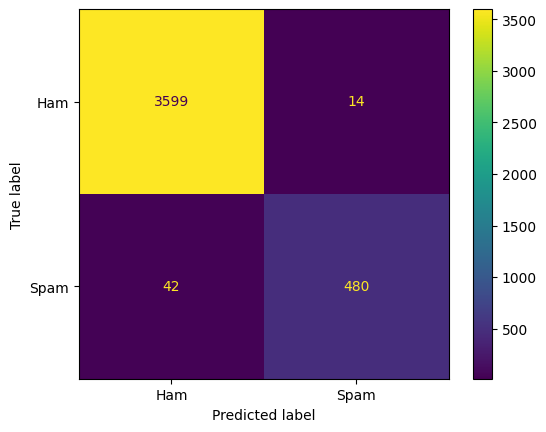

In [159]:
cm = confusion_matrix(TRAIN_LABELS, scores_tv_final["Predictions"][0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot();

Reasonable results on the training set.

# 9) Evaluating the test set <a id='section_9'></a>

First, I'll fit the final model to the training data:

In [160]:
final_SGD = SGDClassifier(alpha=0.0001, l1_ratio=0.125, penalty="elasticnet", random_state=rng)
final_SGD.fit(X_train_processed.toarray(), TRAIN_LABELS)

SGDClassifier(l1_ratio=0.125, penalty='elasticnet',
              random_state=RandomState(MT19937) at 0x14C5F1840)

Transforming the test data with the pre-processing pipeline:

In [161]:
X_test_processed = pre_processer_pipeline.transform(X_test)
TEST_LABELS = y_test

Predictions on the test set:

In [162]:
y_test_pred = final_SGD.predict(X_test_processed)

print(f"Precision: {precision_score(TEST_LABELS, y_test_pred):.2%}")
print(f"Recall: {recall_score(TEST_LABELS, y_test_pred):.2%}")
print(f"F1 Score: {f1_score(TEST_LABELS, y_test_pred):.2%}")

Precision: 98.31%
Recall: 88.55%
F1 Score: 93.17%


Final confusion matrix of the test set results:

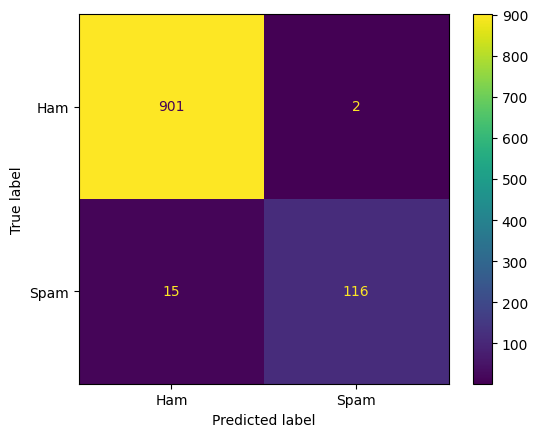

In [163]:
cm_test = confusion_matrix(TEST_LABELS, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Ham", "Spam"])
disp.plot();

# 10) Final comments <a id='section_10'></a>

- The hold-out test set predictions were very precise: only 2 out of 903 ham messages were mis-classified. 
- However, 15 out of the 131 spam messages were mis-classified as ham.
- The pre-processing steps in NLP models like this are very important, and there is nearly always room for improvement there.
- For a data set of this size it would also be worthwhile double-checking the labelling, which could contain errors.
- Finally, although I didn't use text embeddings here, that would be another route to explore.